Imports

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from utils.dataset import SICKLE_Dataset
from utils import utae_utils, model_utils
from torch.utils import data
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Dataset

In [39]:
df = pd.read_csv("dataset/sickle_dataset_tabular.csv")

In [40]:
train_df = df[df.SPLIT == "train"].reset_index(drop=True)
val_df = df[df.SPLIT == "val"].reset_index(drop=True)
test_df = df[df.SPLIT == "test"].reset_index(drop=True)

In [41]:
# Configuration dictionary for dataset
dataset_config = {
    'data_dir': 'dataset_50_per/',
    'satellites': {
        "S2": {
            "bands": ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'],
            "rgb_bands": [3, 2, 1],
            "mask_res": 10,
            "img_size": (32, 32),
        }
    },
    'ignore_index': -999,
    'transform': None,
    'actual_season': False,
    'phase': 'eval'  # Assuming phase could be 'train' or 'eval' based on your setup
}

In [42]:
dt_train = SICKLE_Dataset(df= train_df, **dataset_config)

In [43]:
print(dt_train[0][0])

{'S2': (array([[[[    0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.],
         [    0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.],
         [    0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.,     0.,     0.,     0.,
              0.,     0.,     0.,     0.],
         [    0.,     0.,     0.,     0.,     0.,     0.,     0.,
     

In [44]:
dt_val = SICKLE_Dataset(df= val_df, **dataset_config)

In [45]:
np.set_printoptions(threshold=np.inf)

In [46]:
print(dt_train)

In [47]:
print(len(dt_train))
print(len(dt_val))

1937
227


In [48]:
#  WRITTEN RANDOM VALUES HERE TO SEE IF CODE IS WORKING
batch_size = 227
num_workers = 5

Dataloaders

In [49]:
collate_fn = lambda x: utae_utils.pad_collate(x, pad_value=0)
train_loader = data.DataLoader(
    dt_train,
    batch_size=1937,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
)
val_loader = data.DataLoader(
    dt_val,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
)

In [50]:
batch_data, masks = next(iter(train_loader))

/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [1404309504], which does not match the required output shape [1937, 59, 12, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/Resize.cpp:17.)
  return torch.stack(batch, 0, out=out)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [114283], which does not match the required output shape [1937, 59]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(

In [51]:
val_batch_data, val_masks = next(iter(val_loader))

/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [170151936], which does not match the required output shape [227, 61, 12, 32, 32]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at /opt/conda/conda-bld/pytorch_1666643016022/work/aten/src/ATen/native/Resize.cpp:17.)
  return torch.stack(batch, 0, out=out)
/home/dlpl/code/SICKLE/utils/utae_utils.py:37: UserWarning: An output with one or more elements was resized since it had shape [13847], which does not match the required output shape [227, 61]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). 

In [52]:
print(len(val_masks['crop_yield']))

227


In [53]:
task= "crop_yield"

In [54]:
for sat in dataset_config['satellites'].keys():
        (samples, dates) = batch_data[sat]
        print(f"-----------{sat}------------")
        print("Samples Shape", samples.shape, "Masks Shape", masks["crop_type"].shape)
        print("dates", dates[0])
        print("Samples", torch.unique(samples[0]))
        print("Masks", torch.unique(masks[task]))

-----------S2------------
Samples Shape torch.Size([1937, 59, 12, 32, 32]) Masks Shape torch.Size([1937, 32, 32])
dates tensor([  4,   7,  12,  14,  22,  29,  39,  42,  57,  59,  67,  69,  89, 102,
        104, 107, 112, 117, 119, 149, 154, 159, 164, 179,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0])
Samples tensor([0.0000e+00, 1.0000e+00, 8.0000e+00,  ..., 1.5812e+04, 1.5933e+04,
        1.5987e+04])
Masks tensor([-999.0000,   24.0000,   28.2759,   28.9286,   32.1429,   33.3333,
          37.2727,   37.3333,   37.5000,   38.6667,   40.0000,   40.4444,
          41.0256,   41.5385,   42.6316,   43.0769,   44.1379,   45.0000,
          45.5172,   45.7895,   46.1538,   47.0270,   47.5676,   48.0000,
          48.2759,   49.2308,   50.0000,   51.1111,   51.6667,   53.3333,
          54.3750,   54.6667,   55.6522,   56.2500,   56.5517,   

In [55]:
for i in range(100):
    a = torch.unique(masks[task][i])
    print(a)

tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.,   48.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.0000,  124.4444,  130.5263,  610.0000], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.0000,  132.7273], dtype=torch.float64)
tensor([-999.], dtype=torch.float64)
tensor([-999.], 

In [56]:
print(batch_data)

{'S2': [tensor([[[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]],

          [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [3.5320e+03, 3.5320e+03, 3.5860e+03,  ..., 3.6180e+03,
            3.6040e+03, 3.6260e+03],
           [3.4920e+03, 3.5220e+03, 3.5720e+03,  ..., 3.6320e+03,
            3.6460e+03, 3.6460e+03],
           ...,
           [3.6840e+03, 3.6540e

In [57]:
print(masks['crop_yield'])

tensor([[[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.]],

        [[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.]],

        [[-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [-999., -999., -999.,  ..., -999., -999., -999.],
         ...,
         [-999., -999., -999.,  ..., -999., -999., -999.],
         [

In [58]:
print("Original batch_data['S2'][0] shape:", batch_data['S2'][0].shape)  
print("Original masks['crop_yield'] shape:", masks['crop_yield'].shape)  

Original batch_data['S2'][0] shape: torch.Size([1937, 59, 12, 32, 32])
Original masks['crop_yield'] shape: torch.Size([1937, 32, 32])


In [59]:
print("Original batch_data['S2'][0] shape:", val_batch_data['S2'][0].shape)  
print("Original masks['crop_yield'] shape:", val_masks['crop_yield'].shape)  

Original batch_data['S2'][0] shape: torch.Size([227, 61, 12, 32, 32])
Original masks['crop_yield'] shape: torch.Size([227, 32, 32])


In [60]:
import torch

# Assuming 'batch_data' is your loaded batch data with shape [100, 74, 12, 32, 32]
# Indices for Red and NIR bands (assuming index starts at 0 and Band 4 is at index 3 and Band 8 is at index 7)
red_band_index = 3
nir_band_index = 7

# Extracting the Red and NIR bands
red = batch_data['S2'][0][:, :, red_band_index, :, :]  # shape [100, 74, 32, 32]
nir = batch_data['S2'][0][:, :, nir_band_index, :, :]  # shape [100, 74, 32, 32]

# Calculate NDVI
ndvi = (nir - red) / (nir + red + 1e-10)  # Adding a small number to avoid division by zero

# Example: Flatten NDVI to use as features, you may choose to reshape or summarize differently based on your needs
ndvi_flat = ndvi.reshape(ndvi.shape[0], -1)  # Flattening each image in the batch

print("NDVI calculated with shape:", ndvi.shape)

NDVI calculated with shape: torch.Size([1937, 59, 32, 32])


In [61]:
# FOR VAL

# Extracting the Red and NIR bands
val_red = val_batch_data['S2'][0][:, :, red_band_index, :, :]  # shape [100, 74, 32, 32]
val_nir = val_batch_data['S2'][0][:, :, nir_band_index, :, :]  # shape [100, 74, 32, 32]

# Calculate NDVI
val_ndvi = (val_nir - val_red) / (val_nir + val_red + 1e-10)  # Adding a small number to avoid division by zero

# Example: Flatten NDVI to use as features, you may choose to reshape or summarize differently based on your needs
val_ndvi_flat = val_ndvi.reshape(val_ndvi.shape[0], -1)  # Flattening each image in the batch

print("NDVI calculated with shape:", val_ndvi.shape)

NDVI calculated with shape: torch.Size([227, 61, 32, 32])


In [62]:
print(ndvi_flat.shape)

torch.Size([1937, 60416])


In [63]:
# Temporal aggregation - using the mean as an example
ndvi_mean = torch.mean(ndvi, dim=1)  # Now shape [100, 32, 32], mean over temporal dimension

In [64]:
# Assuming ndvi_mean is correctly shaped as [100, 32, 32]
X_train = ndvi_mean.reshape(-1, 32*32)  # This now correctly reshapes to [100, 1024] as intended
y_train = masks['crop_yield'].reshape(-1)  # Flatten masks to [100 * 1024]

# Since each pixel across each image in the batch is now a sample:
X_train = X_train.reshape(-1, 1)  # Reshape X_train to [100*1024, 1] where each row is a pixel feature vector
y_train = y_train.flatten()  # Ensure y_train is a flat array [100*1024]

# Now X_train and y_train should be aligned:
print("X_train shape:", X_train.shape)  # Should be (102400, 1)
print("y_train shape:", y_train.shape)  # Should be (102400,)

# Filter out invalid data points where y_train is -999
valid_indices = y_train != -999
X_train = X_train[valid_indices]
y_train = y_train[valid_indices]

X_train shape: torch.Size([1983488, 1])
y_train shape: torch.Size([1983488])


In [65]:
# Proceed to train the RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [66]:
# Assuming val_ndvi and val_masks are available
# Temporal aggregation (mean NDVI over temporal dimension)
val_ndvi_mean = torch.mean(val_ndvi, dim=1)  # [batch_size, height, width]

# Reshape validation NDVI to match the training data's shape
X_val = val_ndvi_mean.reshape(-1, 32*32)  # Flatten to [batch_size, features]
y_val = val_masks['crop_yield'].reshape(-1)  # Flatten masks to [batch_size * height * width]
print(X_val.shape)
print(y_val.shape)


torch.Size([227, 1024])
torch.Size([232448])


In [67]:
print(len(y_val))

232448


In [68]:
# Reshape X_val to have one pixel per row, matching the y_val structure
X_val = X_val.reshape(-1, 1)  # This should result in [100*1024, 1], i.e., [102400, 1]
print("Reshaped X_val:", X_val.shape)
print("y_val shape:", y_val.shape)

# Proceed with filtering out invalid data points where y_val is -999
valid_indices_val = y_val != -999
X_val = X_val[valid_indices_val]
y_val = y_val[valid_indices_val]

Reshaped X_val: torch.Size([232448, 1])
y_val shape: torch.Size([232448])


In [69]:
print(X_val)

tensor([[0.1962],
        [0.1923],
        [0.1912],
        [0.1850],
        [0.1810],
        [0.1823],
        [0.1949],
        [0.1930],
        [0.1889],
        [0.1875],
        [0.1975],
        [0.1971],
        [0.2044],
        [0.2035],
        [0.2025],
        [0.2051],
        [0.2073],
        [0.2070],
        [0.2094],
        [0.2121],
        [0.1915],
        [0.1919],
        [0.1941],
        [0.1954],
        [0.1868],
        [0.1841],
        [0.1867],
        [0.1925],
        [0.1898],
        [0.1872],
        [0.1863],
        [0.1903],
        [0.1929],
        [0.1904],
        [0.1891],
        [0.1905],
        [0.1800],
        [0.1818],
        [0.1810],
        [0.1850],
        [0.1805],
        [0.1834],
        [0.1819],
        [0.1829],
        [0.1820],
        [0.1846],
        [0.1827],
        [0.1834],
        [0.1818],
        [0.1840],
        [0.1830],
        [0.1848],
        [0.1549],
        [0.1604],
        [0.1331],
        [0

Validation MSE: 7125.10065563013
Validation MAE: 56.08180614809857
Validation R2 Score: -1.8950649376028497


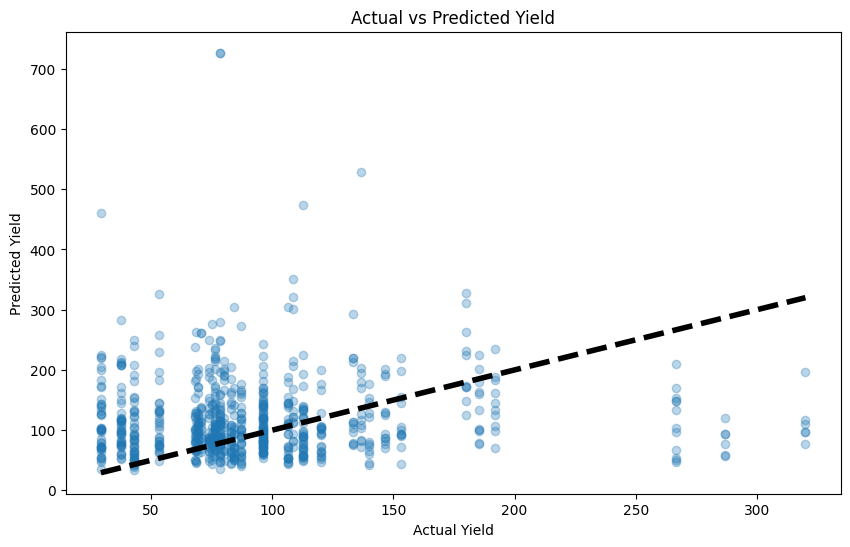

In [70]:

# Predict with the trained RandomForest model
y_pred = rf_model.predict(X_val)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

# Visualization (Optional but recommended for inspection)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.show()

Validation MAPE: 81.70433102545225
Validation MSE: 7125.10065563013
Validation MAE: 56.08180614809857
Validation R2 Score: -1.8950649376028497


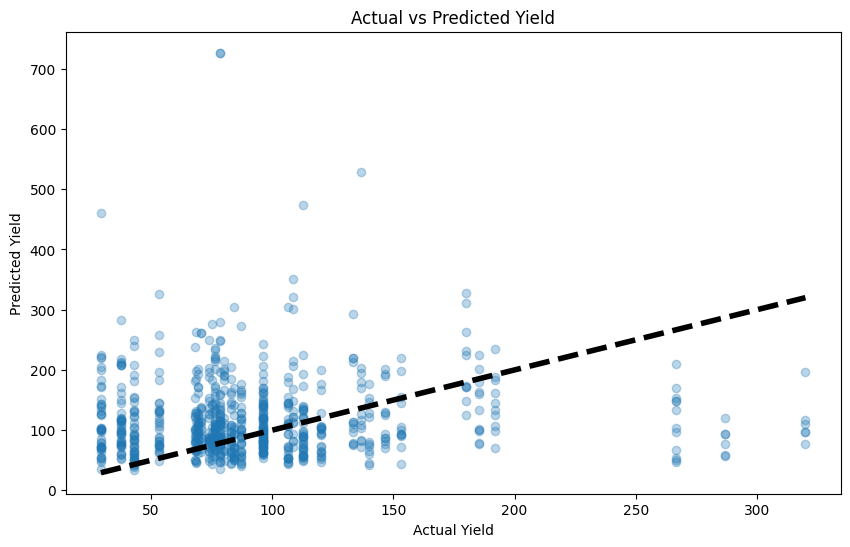

In [71]:
import numpy as np

def calculate_mape(y_true, y_pred):
    """ Calculate MAPE avoiding division by zero and convert to percentage """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0  # Ensure we don't divide by zero
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Predict with the trained RandomForest model
y_pred = rf_model.predict(X_val)

# Calculate MAPE
mape = calculate_mape(y_val, y_pred)
print("Validation MAPE:", mape)

# Evaluate the model performance using other metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Validation MSE:", mse)
print("Validation MAE:", mae)
print("Validation R2 Score:", r2)

# Visualization (Optional but recommended for inspection)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.3)
plt.xlabel('Actual Yield')
plt.ylabel('Predicted Yield')
plt.title('Actual vs Predicted Yield')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.show()

In [72]:
import numpy as np
np.save('y_pred_s2_50.npy',y_pred)

Dataset Exploration

In [73]:
# 100 : 78.9
# 20 : 83.9
# 50 : 81.7

In [74]:
# import rasterio
# import numpy as np
# path = "dataset/masks/10m/2068.tif"

# np.set_printoptions(threshold=np.inf)
# with rasterio.open(path, 'r') as fp:
#     mask = fp.read()

# print(mask[0])